# Chronic Kidney Disease — Improved ML Pipeline with Hyperparameter Tuning

**Improvements over previous version:**
1. ✅ `RandomizedSearchCV` দিয়ে hyperparameter tuning (RF, GB, HistGB, SVM, KNN, LR, XGB)
2. ✅ XGBoost model যোগ করা হয়েছে
3. ✅ Tuned best models দিয়ে Soft Voting Ensemble
4. ✅ Learning Curves (overfitting/underfitting চেক)
5. ✅ Precision-Recall Curve সব model এর জন্য
6. ✅ ROC Curve comparison
7. ✅ সব পুরনো fix বজায় রাখা হয়েছে (no data leakage)

**Pipeline Steps:**
1. Load & Explore Datasets
2. Harmonize & Merge
3. Clean Target
4. Stratified Train/Test Split (80/20)
5. Median Imputation (train-only fit)
6. SMOTE Oversampling (training only)
7. Feature Scaling (train-only fit)
8. Ensemble Feature Selection (Chi2 + MI + RFE)
9. **Hyperparameter Tuning (RandomizedSearchCV)**
10. 10-Fold Stratified Cross-Validation (tuned models)
11. Test Set Evaluation (8 Classifiers + tuned)
12. Soft Voting Ensemble (tuned best models)
13. Confusion Matrices
14. ROC & Precision-Recall Curves
15. Learning Curves
16. Model Comparison Plot
17. SHAP Explainability
18. Save All Results

In [4]:
# ─────────────────────────────────────────────
# 1. IMPORTS
# ─────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    cross_validate, RandomizedSearchCV,
    learning_curve
)
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import (chi2, mutual_info_classif,
                                       SelectKBest, RFE)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve,
    precision_recall_curve, average_precision_score
)
from statsmodels.stats.proportion import proportion_confint

# XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
    print('✅ XGBoost available')
except ImportError:
    HAS_XGB = False
    print('⚠️  XGBoost not installed — skipping (pip install xgboost)')

import shap
from scipy.stats import randint, uniform, loguniform

print('=' * 65)
print('  CHRONIC KIDNEY DISEASE — IMPROVED ML PIPELINE')
print('=' * 65)
print('✅ All libraries imported\n')

✅ XGBoost available
  CHRONIC KIDNEY DISEASE — IMPROVED ML PIPELINE
✅ All libraries imported



In [5]:
# ─────────────────────────────────────────────
# 2. LOAD DATASETS
# ─────────────────────────────────────────────
print('STEP 1: LOADING DATASETS')
print('-' * 45)

df1 = pd.read_csv('/content/chronic_kidney_disease.csv')
df1.columns = df1.columns.str.strip()
df1.replace('?', np.nan, inplace=True)
print(f'Dataset 1 (UCI CKD)      shape: {df1.shape}')

df2 = pd.read_csv('/content/Chronic_Kidney_Dsease_data.csv')
print(f'Dataset 2 (Extended CKD) shape: {df2.shape}\n')

df1.head()

STEP 1: LOADING DATASETS
---------------------------------------------
Dataset 1 (UCI CKD)      shape: (400, 25)
Dataset 2 (Extended CKD) shape: (1659, 54)



,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [6]:
# ─────────────────────────────────────────────
# 3. HARMONIZE & MERGE
# ─────────────────────────────────────────────
print('STEP 2: HARMONIZE & MERGE')
print('-' * 45)

# ── UCI Dataset ──
d1 = df1.copy()
d1['class'] = d1['class'].str.strip().str.replace('\t', '')
d1['target'] = d1['class'].map({'ckd': 1, 'notckd': 0})
d1.drop(columns=['class'], inplace=True)

uci_num = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc',
           'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
uci_cat = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']

le = LabelEncoder()
for col in uci_cat:
    if col in d1.columns:
        mask = d1[col].notna() & (d1[col].astype(str) != 'nan')
        vals = d1.loc[mask, col].astype(str)
        if len(vals) > 0:
            le.fit(vals)
            d1.loc[mask, col] = le.transform(vals)
            d1.loc[~mask, col] = np.nan

for col in uci_num:
    if col in d1.columns:
        d1[col] = pd.to_numeric(d1[col], errors='coerce')

d1_fin = d1[uci_num + uci_cat + ['target']].copy()
d1_fin['_src'] = 'uci'

# ── Extended Dataset ──
d2 = df2.copy()
d2_sel = pd.DataFrame()
d2_sel['age']    = d2['Age']
d2_sel['bp']     = d2['SystolicBP']
d2_sel['sc']     = d2['SerumCreatinine']
d2_sel['bu']     = d2['BUNLevels']
d2_sel['hemo']   = d2['HemoglobinLevels']
d2_sel['sod']    = d2['SerumElectrolytesSodium']
d2_sel['pot']    = d2['SerumElectrolytesPotassium']
d2_sel['bgr']    = d2['FastingBloodSugar']
d2_sel['htn']    = d2['FamilyHistoryHypertension'].astype(float)
d2_sel['dm']     = d2['FamilyHistoryDiabetes'].astype(float)
d2_sel['target'] = d2['Diagnosis'].astype(int)
d2_sel['_src']   = 'ext'

for col in d1_fin.columns:
    if col not in d2_sel.columns:
        d2_sel[col] = np.nan

# ── Merge ──
merged = pd.concat([d1_fin, d2_sel], ignore_index=True, sort=False)
merged.drop(columns=['_src'], inplace=True)
merged.to_csv('merged_ckd_dataset.csv', index=False)

print(f'✅ Merged shape : {merged.shape}')
print(f'   CKD     (1) : {(merged["target"] == 1).sum()}')
print(f'   Not CKD (0) : {(merged["target"] == 0).sum()}')
print('💾 Saved : merged_ckd_dataset.csv\n')

merged.head()

STEP 2: HARMONIZE & MERGE
---------------------------------------------
✅ Merged shape : (2059, 25)
   CKD     (1) : 1774
   Not CKD (0) : 284
💾 Saved : merged_ckd_dataset.csv



,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc,pcc,ba,htn,dm,cad,appet,pe,ane,target
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,1,0,1.0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,2,1,1,1.0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,2,2,1,1.0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,1,0,1.0


In [7]:
# ─────────────────────────────────────────────
# 4. CLEAN TARGET
# ─────────────────────────────────────────────
print('STEP 3: CLEAN TARGET')
print('-' * 45)

merged_clean = merged.dropna(subset=['target'])
X_raw = merged_clean.drop(columns=['target'])
y = merged_clean['target'].astype(int)

print(f'Rows dropped (NaN target): {len(merged) - len(merged_clean)}')
print(f'Total records : {len(merged_clean)}  |  Features : {X_raw.shape[1]}')
print(f'Class distribution:\n{y.value_counts()}\n')

STEP 3: CLEAN TARGET
---------------------------------------------
Rows dropped (NaN target): 1
Total records : 2058  |  Features : 24
Class distribution:
target
1    1774
0     284
Name: count, dtype: int64



In [8]:
# ─────────────────────────────────────────────
# 5. STRATIFIED TRAIN/TEST SPLIT 80/20
# FIX: Split FIRST before any fitting (prevents data leakage)
# ─────────────────────────────────────────────
print('STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)')
print('-' * 45)

X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(
    X_raw, y, test_size=0.2, random_state=42, stratify=y)

print(f'Train : {X_tr_raw.shape[0]}  |  Test : {X_te_raw.shape[0]}')
print(f'Train class dist : {dict(y_tr.value_counts().sort_index())}')
print(f'Test  class dist : {dict(y_te.value_counts().sort_index())}\n')

STEP 4: STRATIFIED TRAIN/TEST SPLIT (80/20)
---------------------------------------------
Train : 1646  |  Test : 412
Train class dist : {0: np.int64(227), 1: np.int64(1419)}
Test  class dist : {0: np.int64(57), 1: np.int64(355)}



In [9]:
# ─────────────────────────────────────────────
# 6. MEDIAN IMPUTATION (train-only fit)
# ─────────────────────────────────────────────
print('STEP 5: MEDIAN IMPUTATION (train-only fit)')
print('-' * 45)

imp = SimpleImputer(strategy='median')
X_tr_imp = pd.DataFrame(imp.fit_transform(X_tr_raw), columns=X_tr_raw.columns)
X_te_imp = pd.DataFrame(imp.transform(X_te_raw),     columns=X_te_raw.columns)

print(f'Train missing after imputation : {X_tr_imp.isnull().sum().sum()}')
print(f'Test  missing after imputation : {X_te_imp.isnull().sum().sum()}\n')

STEP 5: MEDIAN IMPUTATION (train-only fit)
---------------------------------------------
Train missing after imputation : 0
Test  missing after imputation : 0



In [10]:
# ─────────────────────────────────────────────
# 7. SMOTE OVERSAMPLING (Training only)
# ─────────────────────────────────────────────
print('STEP 6: SMOTE OVERSAMPLING (train only)')
print('-' * 45)

X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_tr_imp, y_tr)
print(f'After SMOTE → {X_tr_res.shape[0]} samples')
print(f'Class dist : {dict(pd.Series(y_tr_res).value_counts().sort_index())}\n')

STEP 6: SMOTE OVERSAMPLING (train only)
---------------------------------------------
After SMOTE → 2838 samples
Class dist : {0: np.int64(1419), 1: np.int64(1419)}



In [11]:
# ─────────────────────────────────────────────
# 8. FEATURE SCALING (train-only fit)
# ─────────────────────────────────────────────
print('STEP 7: FEATURE SCALING (train-only fit)')
print('-' * 45)

sc_scaler = StandardScaler()
X_tr_sc = pd.DataFrame(sc_scaler.fit_transform(X_tr_res), columns=X_tr_res.columns)
X_te_sc  = pd.DataFrame(sc_scaler.transform(X_te_imp),    columns=X_te_imp.columns)

print('✅ StandardScaler applied\n')

STEP 7: FEATURE SCALING (train-only fit)
---------------------------------------------
✅ StandardScaler applied



STEP 8: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)
---------------------------------------------
Chi-Square  (12) : ['al', 'ane', 'appet', 'ba', 'bp', 'cad', 'dm', 'htn', 'pcc', 'pe', 'sc', 'su']
Mutual Info (12)  : ['age', 'bgr', 'bp', 'dm', 'hemo', 'htn', 'pcv', 'rbcc', 'sc', 'sg', 'sod', 'wbcc']
RFE         (12) : ['age', 'bgr', 'bp', 'bu', 'dm', 'hemo', 'htn', 'pcv', 'pot', 'rbcc', 'sc', 'sod']

✅ Consensus (10) : ['age', 'bgr', 'bp', 'dm', 'hemo', 'htn', 'pcv', 'rbcc', 'sc', 'sod']



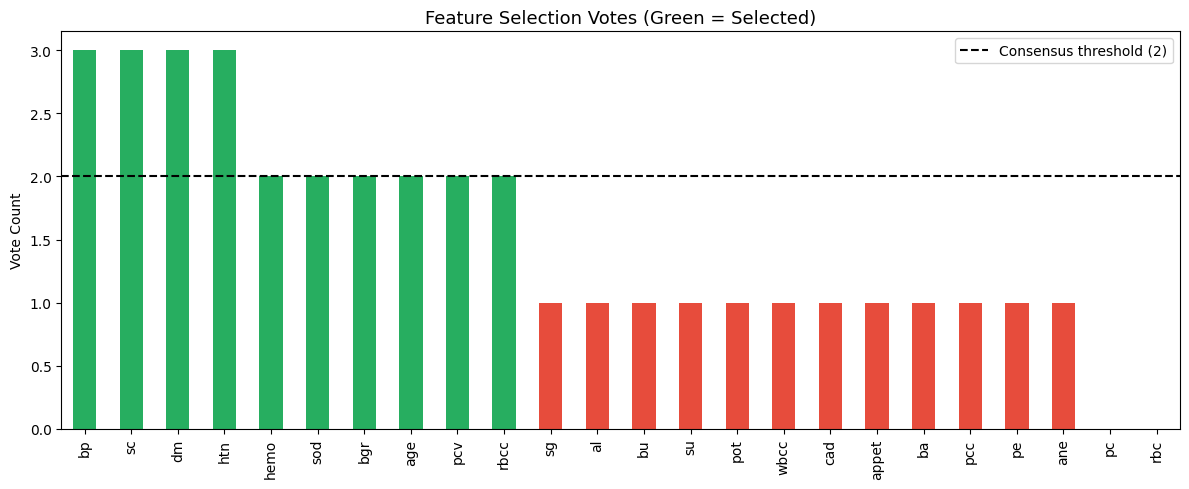

📊 Saved: feature_selection_votes.png


In [12]:
# ─────────────────────────────────────────────
# 9. ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)
# ─────────────────────────────────────────────
print('STEP 8: ENSEMBLE FEATURE SELECTION (Chi2 + MI + RFE)')
print('-' * 45)

n_feat = max(1, X_tr_sc.shape[1] // 2)

# Chi-Square: needs non-negative → shift
X_tr_nn = X_tr_sc - X_tr_sc.min()
X_te_nn = X_te_sc - X_tr_sc.min()
chi_sel = SelectKBest(chi2, k=n_feat).fit(X_tr_nn, y_tr_res)
chi_feats = set(X_tr_sc.columns[chi_sel.get_support()])

# Mutual Info
mi_sel = SelectKBest(mutual_info_classif, k=n_feat).fit(X_tr_sc, y_tr_res)
mi_feats = set(X_tr_sc.columns[mi_sel.get_support()])

# RFE with RF
rfe = RFE(RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1),
          n_features_to_select=n_feat).fit(X_tr_sc, y_tr_res)
rfe_feats = set(X_tr_sc.columns[rfe.get_support()])

# Consensus: selected by ≥ 2 methods
votes = {}
for f in X_tr_sc.columns:
    votes[f] = (f in chi_feats) + (f in mi_feats) + (f in rfe_feats)

consens = sorted([f for f, v in votes.items() if v >= 2])
if len(consens) < 5:
    consens = sorted(votes, key=votes.get, reverse=True)[:n_feat]

print(f'Chi-Square  ({len(chi_feats)}) : {sorted(chi_feats)}')
print(f'Mutual Info ({len(mi_feats)})  : {sorted(mi_feats)}')
print(f'RFE         ({len(rfe_feats)}) : {sorted(rfe_feats)}')
print(f'\n✅ Consensus ({len(consens)}) : {consens}\n')

X_tr_sel = X_tr_sc[consens].values
X_te_sel = X_te_sc[consens].values
feat_names = consens

# Feature vote bar plot
vote_df = pd.Series(votes).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['#27ae60' if v >= 2 else '#e74c3c' for v in vote_df]
vote_df.plot(kind='bar', ax=ax, color=colors)
ax.axhline(2, color='black', linestyle='--', label='Consensus threshold (2)')
ax.set_title('Feature Selection Votes (Green = Selected)', fontsize=13)
ax.set_ylabel('Vote Count')
ax.legend()
plt.tight_layout()
plt.savefig('feature_selection_votes.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: feature_selection_votes.png')

In [13]:
# ─────────────────────────────────────────────────────────────────
# 10. HYPERPARAMETER TUNING — RandomizedSearchCV
# প্রতিটি model এর জন্য আলাদা param grid দেওয়া হয়েছে
# ─────────────────────────────────────────────────────────────────
print('STEP 9: HYPERPARAMETER TUNING (RandomizedSearchCV)')
print('-' * 60)
print('⏳ এটি কিছুটা সময় নেবে — প্রতিটি model tune হচ্ছে...')
print('-' * 60)

skf_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
N_ITER = 30  # বেশি accuracy চাইলে 50 করুন (কিন্তু বেশি সময় লাগবে)

param_grids = {
    'Random Forest': (
        RandomForestClassifier(random_state=42, n_jobs=-1),
        {
            'n_estimators':      randint(100, 500),
            'max_depth':         [None, 10, 20, 30],
            'min_samples_split': randint(2, 10),
            'min_samples_leaf':  randint(1, 5),
            'max_features':      ['sqrt', 'log2', 0.5],
        }
    ),
    'Gradient Boosting': (
        GradientBoostingClassifier(random_state=42),
        {
            'n_estimators':  randint(100, 400),
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth':     randint(3, 8),
            'subsample':     uniform(0.6, 0.4),
            'min_samples_split': randint(2, 10),
        }
    ),
    'Hist Gradient Boosting': (
        HistGradientBoostingClassifier(random_state=42),
        {
            'max_iter':          randint(100, 500),
            'learning_rate':     loguniform(0.01, 0.3),
            'max_depth':         [None, 5, 10, 15],
            'min_samples_leaf':  randint(10, 50),
            'l2_regularization': loguniform(1e-4, 1.0),
        }
    ),
    'SVM': (
        SVC(probability=True, random_state=42),
        {
            'C':      loguniform(0.01, 100),
            'gamma':  loguniform(1e-4, 1.0),
            'kernel': ['rbf', 'poly'],
        }
    ),
    'KNN': (
        KNeighborsClassifier(n_jobs=-1),
        {
            'n_neighbors': randint(3, 20),
            'weights':     ['uniform', 'distance'],
            'metric':      ['euclidean', 'manhattan', 'minkowski'],
            'p':           [1, 2],
        }
    ),
    'Logistic Regression': (
        LogisticRegression(max_iter=2000, random_state=42),
        {
            'C':       loguniform(0.001, 10),
            'penalty': ['l1', 'l2'],
            'solver':  ['liblinear', 'saga'],
        }
    ),
    'Decision Tree': (
        DecisionTreeClassifier(random_state=42),
        {
            'max_depth':         [None, 5, 10, 15, 20],
            'min_samples_split': randint(2, 20),
            'min_samples_leaf':  randint(1, 10),
            'criterion':         ['gini', 'entropy'],
        }
    ),
}

# XGBoost (যদি installed থাকে)
if HAS_XGB:
    param_grids['XGBoost'] = (
        XGBClassifier(random_state=42, eval_metric='logloss',
                      use_label_encoder=False, n_jobs=-1),
        {
            'n_estimators':  randint(100, 400),
            'learning_rate': loguniform(0.01, 0.3),
            'max_depth':     randint(3, 10),
            'subsample':     uniform(0.6, 0.4),
            'colsample_bytree': uniform(0.5, 0.5),
            'reg_alpha':     loguniform(1e-4, 1.0),
            'reg_lambda':    loguniform(1e-4, 1.0),
        }
    )

best_estimators = {}
tuning_results  = {}

for name, (base_clf, params) in param_grids.items():
    rs = RandomizedSearchCV(
        base_clf, params,
        n_iter=N_ITER,
        cv=skf_tune,
        scoring='roc_auc',
        random_state=42,
        n_jobs=-1,
        refit=True
    )
    rs.fit(X_tr_sel, y_tr_res)
    best_estimators[name] = rs.best_estimator_
    tuning_results[name]  = {
        'Best CV AUC': round(rs.best_score_, 4),
        'Best Params': rs.best_params_
    }
    print(f'  ✅ {name:28s} | Best CV AUC: {rs.best_score_:.4f}')

print('\n🎯 Hyperparameter Tuning সম্পন্ন!\n')

# Best params summary
print('\n📋 Best Hyperparameters:')
print('-' * 60)
for name, result in tuning_results.items():
    print(f'\n{name}:')
    for k, v in result['Best Params'].items():
        if isinstance(v, float):
            print(f'   {k}: {v:.6f}')
        else:
            print(f'   {k}: {v}')

STEP 9: HYPERPARAMETER TUNING (RandomizedSearchCV)
------------------------------------------------------------
⏳ এটি কিছুটা সময় নেবে — প্রতিটি model tune হচ্ছে...
------------------------------------------------------------
  ✅ Random Forest                | Best CV AUC: 0.9827
  ✅ Gradient Boosting            | Best CV AUC: 0.9858
  ✅ Hist Gradient Boosting       | Best CV AUC: 0.9843
  ✅ SVM                          | Best CV AUC: 0.9797
  ✅ KNN                          | Best CV AUC: 0.9821
  ✅ Logistic Regression          | Best CV AUC: 0.8858
  ✅ Decision Tree                | Best CV AUC: 0.9362
  ✅ XGBoost                      | Best CV AUC: 0.9831

🎯 Hyperparameter Tuning সম্পন্ন!


📋 Best Hyperparameters:
------------------------------------------------------------

Random Forest:
   max_depth: 30
   max_features: sqrt
   min_samples_leaf: 1
   min_samples_split: 5
   n_estimators: 413

Gradient Boosting:
   learning_rate: 0.179452
   max_depth: 7
   min_samples_split: 3
   

In [14]:
# ─────────────────────────────────────────────
# 11. 10-FOLD STRATIFIED CROSS-VALIDATION (tuned models)
# ─────────────────────────────────────────────
print('STEP 10: 10-FOLD STRATIFIED CROSS-VALIDATION (Tuned Models)')
print('-' * 60)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_res = {}

for nm, clf in best_estimators.items():
    cv = cross_validate(clf, X_tr_sel, y_tr_res, cv=skf,
                        scoring=['accuracy', 'f1', 'roc_auc'])
    cv_res[nm] = {
        'CV Accuracy': round(cv['test_accuracy'].mean(), 4),
        'CV F1':       round(cv['test_f1'].mean(), 4),
        'CV AUC-ROC':  round(cv['test_roc_auc'].mean(), 4),
        'CV Acc Std':  round(cv['test_accuracy'].std(), 4),
    }
    print(f'  {nm:28s}| Acc:{cv_res[nm]["CV Accuracy"]:.4f}±{cv_res[nm]["CV Acc Std"]:.4f} '
          f'| F1:{cv_res[nm]["CV F1"]:.4f} '
          f'| AUC:{cv_res[nm]["CV AUC-ROC"]:.4f}')

cv_df = pd.DataFrame(cv_res).T
cv_df

STEP 10: 10-FOLD STRATIFIED CROSS-VALIDATION (Tuned Models)
------------------------------------------------------------
  Random Forest               | Acc:0.9412±0.0099 | F1:0.9421 | AUC:0.9843
  Gradient Boosting           | Acc:0.9475±0.0073 | F1:0.9478 | AUC:0.9865
  Hist Gradient Boosting      | Acc:0.9493±0.0084 | F1:0.9496 | AUC:0.9853
  SVM                         | Acc:0.9369±0.0151 | F1:0.9362 | AUC:0.9807
  KNN                         | Acc:0.9253±0.0143 | F1:0.9213 | AUC:0.9821
  Logistic Regression         | Acc:0.7960±0.0192 | F1:0.8051 | AUC:0.8855
  Decision Tree               | Acc:0.8679±0.0199 | F1:0.8643 | AUC:0.9428
  XGBoost                     | Acc:0.9387±0.0090 | F1:0.9392 | AUC:0.9846


,CV Accuracy,CV F1,CV AUC-ROC,CV Acc Std
Random Forest,0.9412,0.9421,0.9843,0.0099
Gradient Boosting,0.9475,0.9478,0.9865,0.0073
Hist Gradient Boosting,0.9493,0.9496,0.9853,0.0084
SVM,0.9369,0.9362,0.9807,0.0151
KNN,0.9253,0.9213,0.9821,0.0143
Logistic Regression,0.7960,0.8051,0.8855,0.0192
Decision Tree,0.8679,0.8643,0.9428,0.0199
XGBoost,0.9387,0.9392,0.9846,0.0090


In [15]:
# ─────────────────────────────────────────────
# 12. TEST SET EVALUATION (Tuned Models)
# ─────────────────────────────────────────────
print('STEP 11: TEST SET EVALUATION')
print('-' * 60)

trained = {}
te_res  = {}

for nm, clf in best_estimators.items():
    clf.fit(X_tr_sel, y_tr_res)
    trained[nm] = clf
    yp   = clf.predict(X_te_sel)
    ypr  = clf.predict_proba(X_te_sel)[:, 1]
    acc  = accuracy_score(y_te, yp)
    f1   = f1_score(y_te, yp)
    auc  = roc_auc_score(y_te, ypr)
    te_res[nm] = {'Test Accuracy': acc, 'Test F1': f1, 'Test AUC-ROC': auc}
    print(f'  {nm:28s}| Acc:{acc:.4f} | F1:{f1:.4f} | AUC:{auc:.4f}')

te_df = pd.DataFrame(te_res).T

# Best model
best_nm = te_df['Test Accuracy'].idxmax()
best_ac = te_df.loc[best_nm, 'Test Accuracy']
ci_l, ci_h = proportion_confint(
    int(best_ac * len(y_te)), len(y_te), method='wilson')

print(f'\n🏆 Best Individual Model : {best_nm}')
print(f'   Accuracy             : {best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]')

# Classification report for best
print(f'\nClassification Report — {best_nm}:')
print(classification_report(y_te, trained[best_nm].predict(X_te_sel),
                             target_names=['Not CKD', 'CKD']))

te_df

STEP 11: TEST SET EVALUATION
------------------------------------------------------------
  Random Forest               | Acc:0.9053 | F1:0.9459 | AUC:0.8692
  Gradient Boosting           | Acc:0.9078 | F1:0.9474 | AUC:0.8489
  Hist Gradient Boosting      | Acc:0.9029 | F1:0.9444 | AUC:0.8527
  SVM                         | Acc:0.8689 | F1:0.9235 | AUC:0.7811
  KNN                         | Acc:0.8350 | F1:0.9006 | AUC:0.8277
  Logistic Regression         | Acc:0.8180 | F1:0.8872 | AUC:0.8619
  Decision Tree               | Acc:0.8252 | F1:0.8938 | AUC:0.8030
  XGBoost                     | Acc:0.9029 | F1:0.9444 | AUC:0.8591

🏆 Best Individual Model : Gradient Boosting
   Accuracy             : 0.9078 | 95% CI:[0.876,0.932]

Classification Report — Gradient Boosting:
              precision    recall  f1-score   support

     Not CKD       0.71      0.56      0.63        57
         CKD       0.93      0.96      0.95       355

    accuracy                           0.91       412
   

,Test Accuracy,Test F1,Test AUC-ROC
Random Forest,0.905340,0.945908,0.869236
Gradient Boosting,0.907767,0.947368,0.848876
Hist Gradient Boosting,0.902913,0.944444,0.852730
SVM,0.868932,0.923513,0.781122
KNN,0.834951,0.900585,0.827675
Logistic Regression,0.817961,0.887218,0.861873
Decision Tree,0.825243,0.893805,0.803039
XGBoost,0.902913,0.944444,0.859106


In [16]:
# ─────────────────────────────────────────────
# 13. SOFT VOTING ENSEMBLE (Top-3 Tuned Models by AUC)
# ─────────────────────────────────────────────
print('STEP 12: SOFT VOTING ENSEMBLE (Top-3 Tuned Models)')
print('-' * 60)

# AUC অনুযায়ী top-3 model বেছে নেওয়া
top3_names = te_df.nlargest(3, 'Test AUC-ROC').index.tolist()
print(f'Top-3 models by AUC: {top3_names}')

ensemble_estimators = [(nm, trained[nm]) for nm in top3_names]

ens = VotingClassifier(estimators=ensemble_estimators, voting='soft')
ens.fit(X_tr_sel, y_tr_res)
yp_e  = ens.predict(X_te_sel)
ypr_e = ens.predict_proba(X_te_sel)[:, 1]

ea = accuracy_score(y_te, yp_e)
ef = f1_score(y_te, yp_e)
eu = roc_auc_score(y_te, ypr_e)

print(f'\n  Ensemble | Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f}')
print('\nClassification Report (Ensemble):')
print(classification_report(y_te, yp_e, target_names=['Not CKD', 'CKD']))

STEP 12: SOFT VOTING ENSEMBLE (Top-3 Tuned Models)
------------------------------------------------------------
Top-3 models by AUC: ['Random Forest', 'Logistic Regression', 'XGBoost']

  Ensemble | Acc:0.9029 | F1:0.9444 | AUC:0.8681

Classification Report (Ensemble):
              precision    recall  f1-score   support

     Not CKD       0.68      0.56      0.62        57
         CKD       0.93      0.96      0.94       355

    accuracy                           0.90       412
   macro avg       0.81      0.76      0.78       412
weighted avg       0.90      0.90      0.90       412



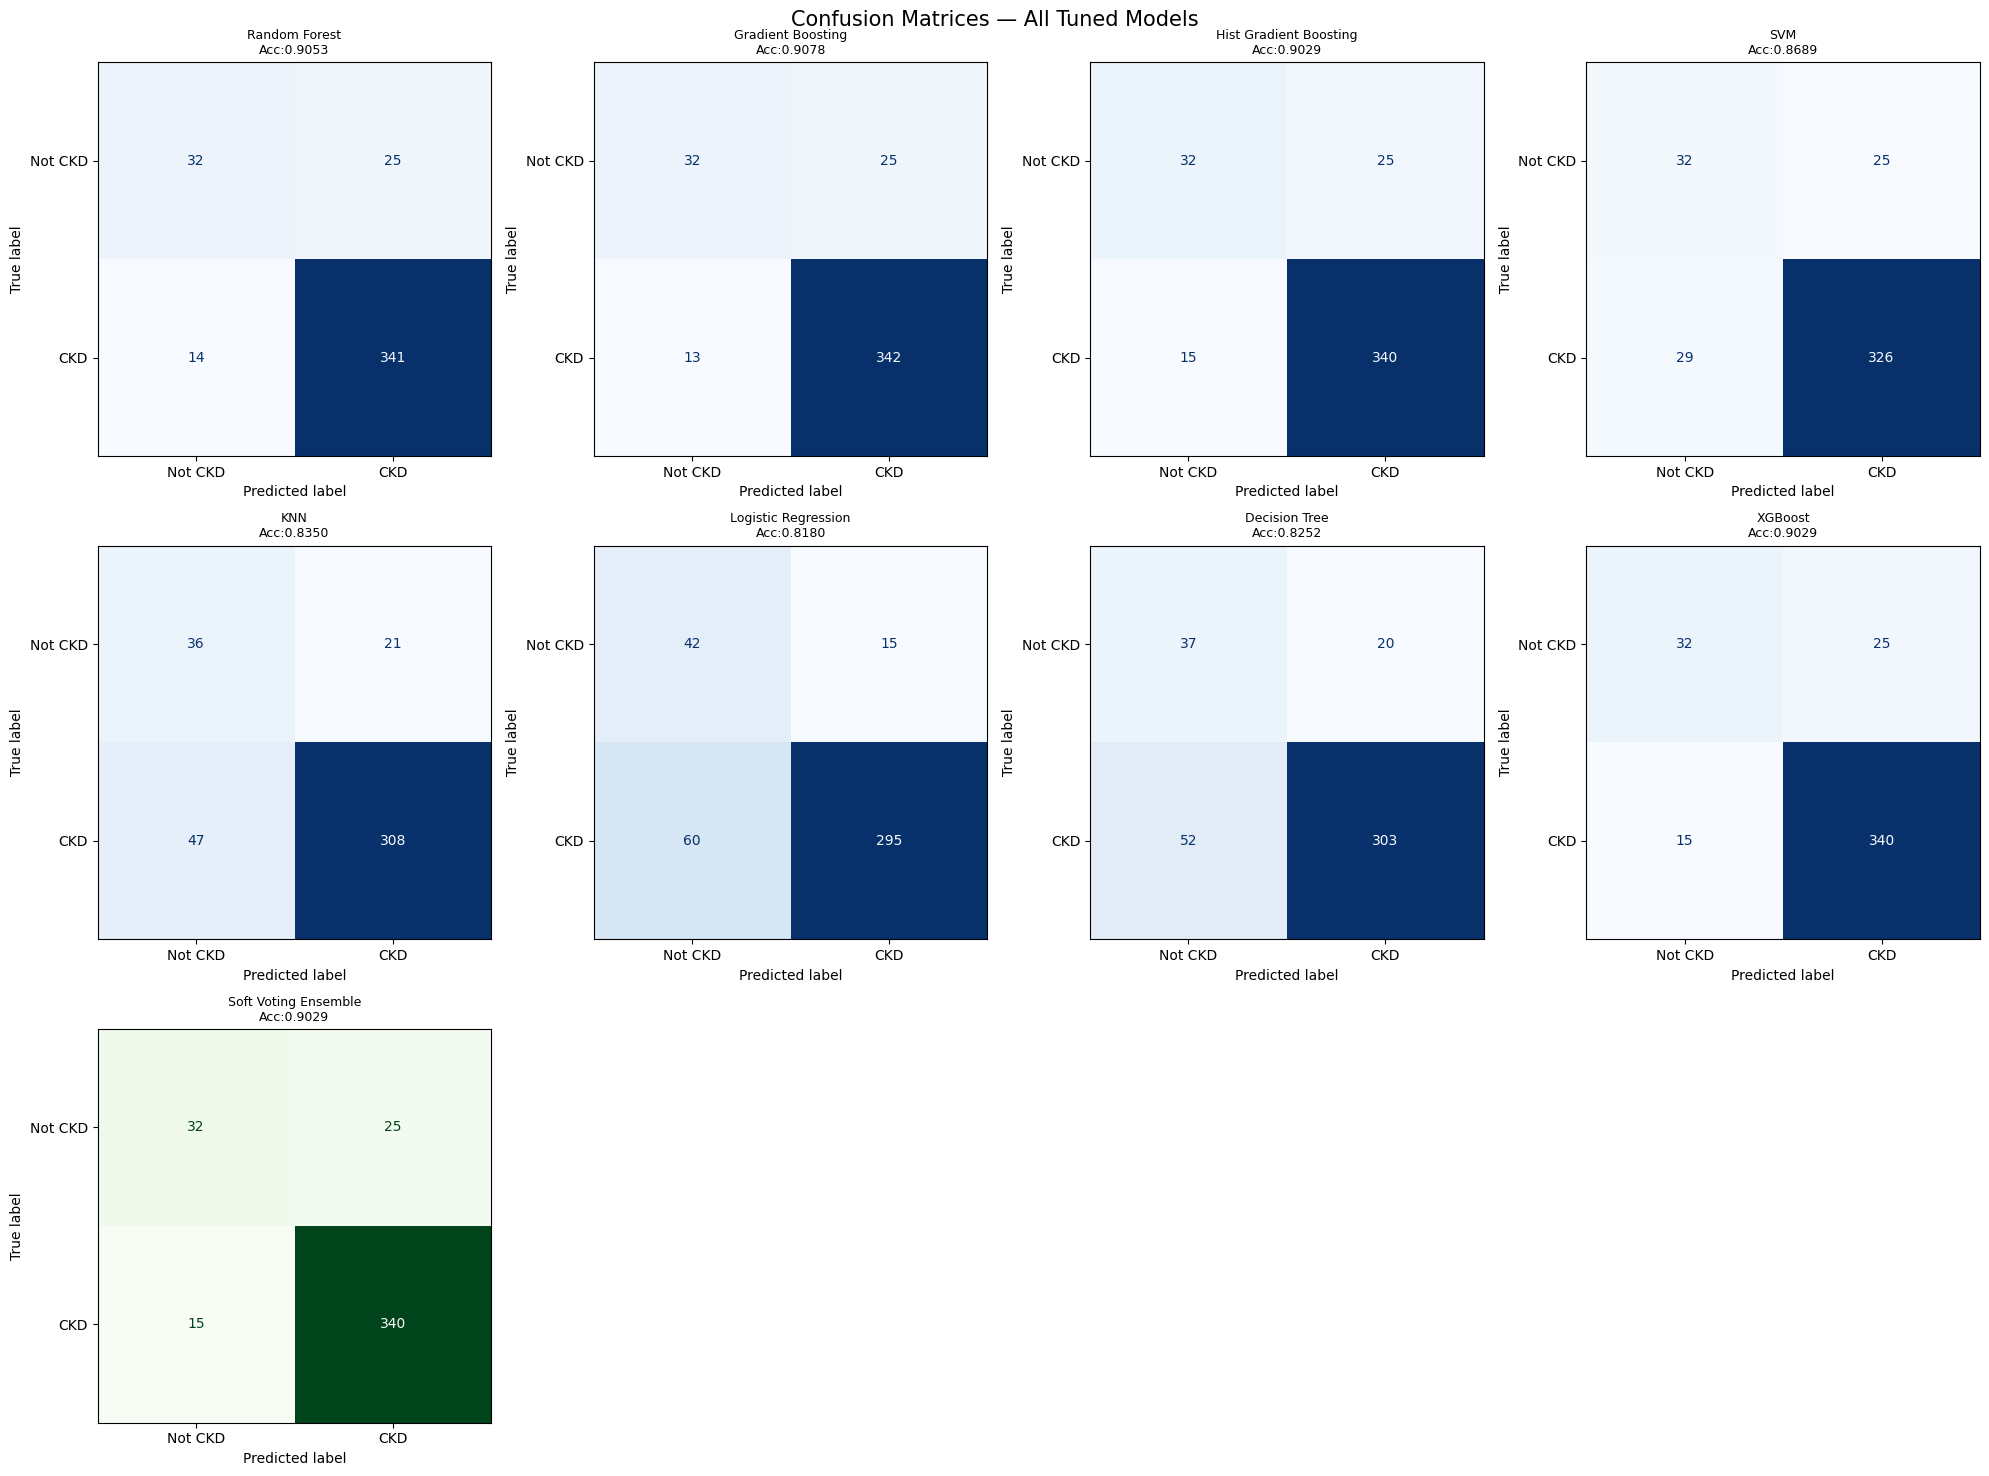

📊 Saved: confusion_matrices.png


In [17]:
# ─────────────────────────────────────────────
# 14. CONFUSION MATRICES
# ─────────────────────────────────────────────
n_models = len(trained) + 1  # +1 for ensemble
ncols = 4
nrows = (n_models + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
ax = axes.flatten()

for i, (nm, clf) in enumerate(trained.items()):
    yp = clf.predict(X_te_sel)
    ConfusionMatrixDisplay(confusion_matrix(y_te, yp),
                           display_labels=['Not CKD', 'CKD']).plot(
        ax=ax[i], colorbar=False, cmap='Blues')
    ax[i].set_title(f'{nm}\nAcc:{accuracy_score(y_te, yp):.4f}', fontsize=9)

ConfusionMatrixDisplay(confusion_matrix(y_te, yp_e),
                       display_labels=['Not CKD', 'CKD']).plot(
    ax=ax[len(trained)], colorbar=False, cmap='Greens')
ax[len(trained)].set_title(f'Soft Voting Ensemble\nAcc:{ea:.4f}', fontsize=9)

# Extra axes hide করা
for j in range(len(trained) + 1, len(ax)):
    ax[j].set_visible(False)

plt.suptitle('Confusion Matrices — All Tuned Models', fontsize=15)
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: confusion_matrices.png')

STEP 13: ROC CURVES
---------------------------------------------


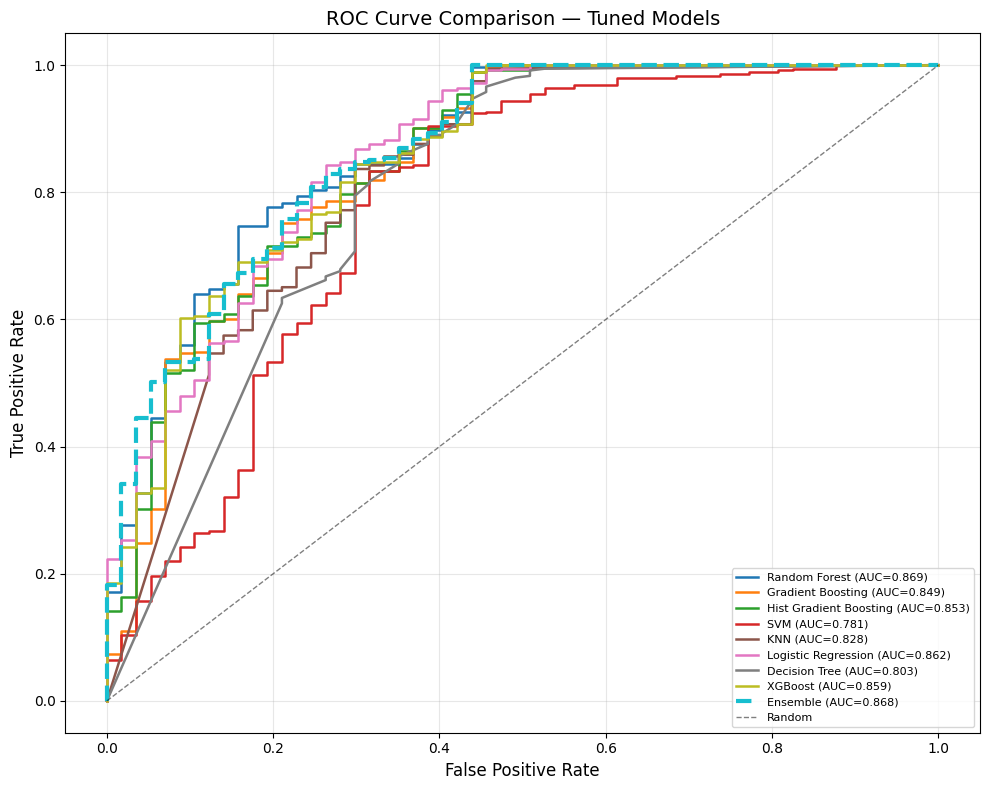

📊 Saved: roc_curves.png


In [18]:
# ─────────────────────────────────────────────
# 15. ROC CURVES — সব model এর তুলনা
# ─────────────────────────────────────────────
print('STEP 13: ROC CURVES')
print('-' * 45)

fig, ax = plt.subplots(figsize=(10, 8))

# Color palette
colors = plt.cm.tab10(np.linspace(0, 1, len(trained) + 1))

for i, (nm, clf) in enumerate(trained.items()):
    ypr = clf.predict_proba(X_te_sel)[:, 1]
    fpr, tpr, _ = roc_curve(y_te, ypr)
    auc = roc_auc_score(y_te, ypr)
    ax.plot(fpr, tpr, color=colors[i], lw=1.8,
            label=f'{nm} (AUC={auc:.3f})')

# Ensemble
fpr_e, tpr_e, _ = roc_curve(y_te, ypr_e)
ax.plot(fpr_e, tpr_e, color=colors[-1], lw=3,
        linestyle='--', label=f'Ensemble (AUC={eu:.3f})')

ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison — Tuned Models', fontsize=14)
ax.legend(loc='lower right', fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: roc_curves.png')

STEP 14: PRECISION-RECALL CURVES
---------------------------------------------


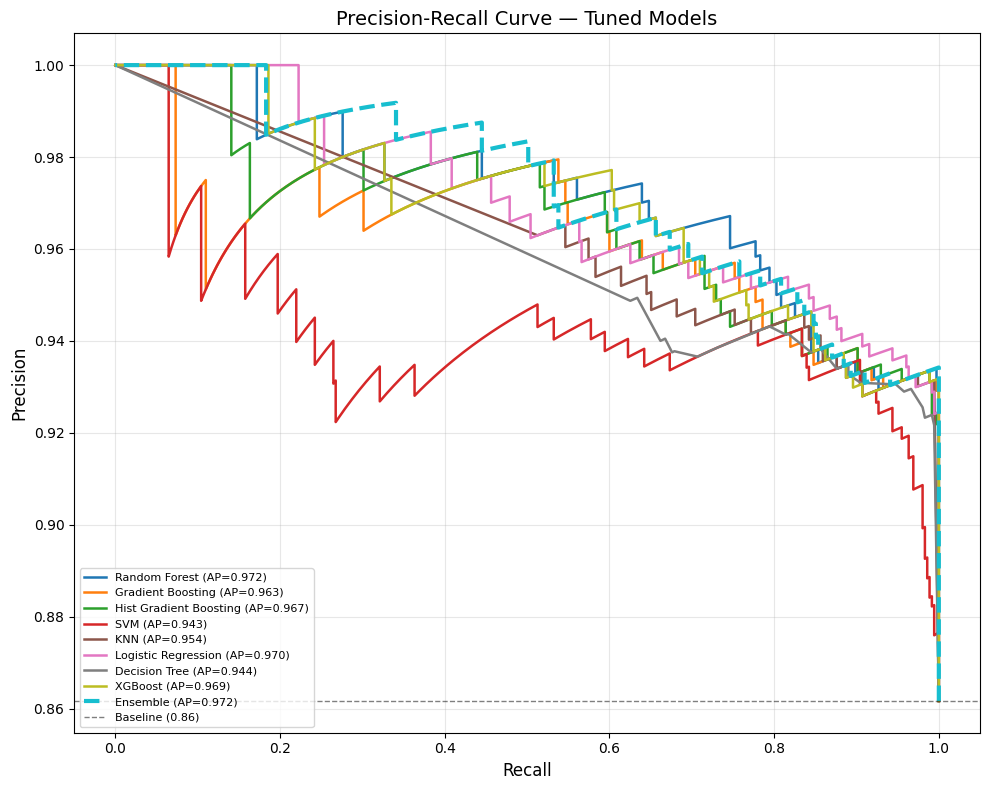

📊 Saved: pr_curves.png


In [19]:
# ─────────────────────────────────────────────
# 16. PRECISION-RECALL CURVES
# ─────────────────────────────────────────────
print('STEP 14: PRECISION-RECALL CURVES')
print('-' * 45)

fig, ax = plt.subplots(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(trained) + 1))

for i, (nm, clf) in enumerate(trained.items()):
    ypr = clf.predict_proba(X_te_sel)[:, 1]
    prec, rec, _ = precision_recall_curve(y_te, ypr)
    ap = average_precision_score(y_te, ypr)
    ax.plot(rec, prec, color=colors[i], lw=1.8,
            label=f'{nm} (AP={ap:.3f})')

# Ensemble
prec_e, rec_e, _ = precision_recall_curve(y_te, ypr_e)
ap_e = average_precision_score(y_te, ypr_e)
ax.plot(rec_e, prec_e, color=colors[-1], lw=3,
        linestyle='--', label=f'Ensemble (AP={ap_e:.3f})')

baseline = y_te.sum() / len(y_te)
ax.axhline(baseline, color='k', linestyle='--', lw=1,
           alpha=0.5, label=f'Baseline ({baseline:.2f})')

ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve — Tuned Models', fontsize=14)
ax.legend(loc='lower left', fontsize=8)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: pr_curves.png')

STEP 15: LEARNING CURVES (Top-3 Models)
---------------------------------------------


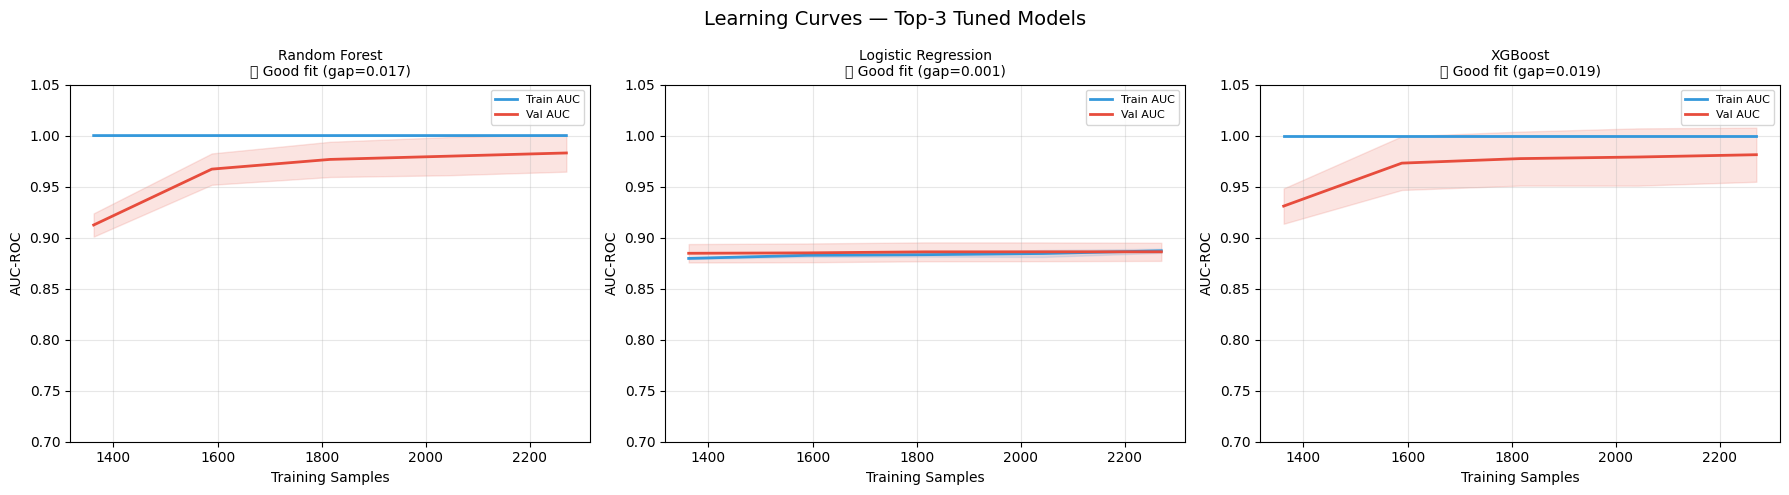

📊 Saved: learning_curves.png


In [20]:
# ─────────────────────────────────────────────
# 17. LEARNING CURVES (Overfitting চেক)
# শুধু top-3 model এর জন্য
# ─────────────────────────────────────────────
print('STEP 15: LEARNING CURVES (Top-3 Models)')
print('-' * 45)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
train_sizes_pct = np.linspace(0.1, 1.0, 10)

for ax, nm in zip(axes, top3_names):
    clf = best_estimators[nm]
    train_sizes, train_scores, val_scores = learning_curve(
        clf, X_tr_sel, y_tr_res,
        train_sizes=train_sizes_pct,
        cv=5, scoring='roc_auc',
        n_jobs=-1
    )
    tr_mean = train_scores.mean(axis=1)
    tr_std  = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std  = val_scores.std(axis=1)

    ax.plot(train_sizes, tr_mean,  label='Train AUC',  color='#3498db', lw=2)
    ax.fill_between(train_sizes, tr_mean - tr_std,  tr_mean + tr_std,
                    alpha=0.15, color='#3498db')
    ax.plot(train_sizes, val_mean, label='Val AUC',    color='#e74c3c', lw=2)
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                    alpha=0.15, color='#e74c3c')

    gap = tr_mean[-1] - val_mean[-1]
    status = '✅ Good fit'
    if gap > 0.05:
        status = '⚠️ Overfit'
    elif val_mean[-1] < 0.85:
        status = '⚠️ Underfit'

    ax.set_title(f'{nm}\n{status} (gap={gap:.3f})', fontsize=10)
    ax.set_xlabel('Training Samples')
    ax.set_ylabel('AUC-ROC')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.set_ylim(0.7, 1.05)

plt.suptitle('Learning Curves — Top-3 Tuned Models', fontsize=14)
plt.tight_layout()
plt.savefig('learning_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: learning_curves.png')

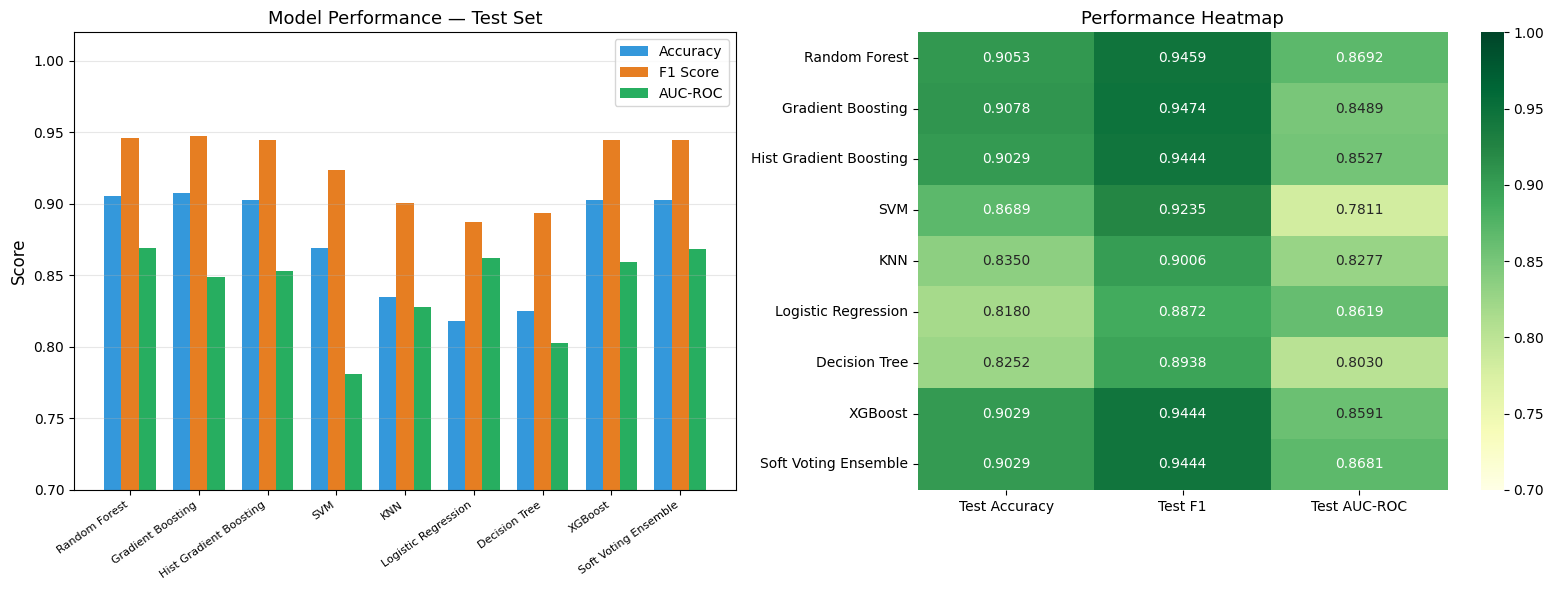

📊 Saved: model_comparison.png


In [21]:
# ─────────────────────────────────────────────
# 18. MODEL COMPARISON PLOT
# ─────────────────────────────────────────────
all_r = te_df.copy()
all_r.loc['Soft Voting Ensemble'] = [ea, ef, eu]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
ax = axes[0]
x = np.arange(len(all_r))
w = 0.25
ax.bar(x - w, all_r['Test Accuracy'], w, label='Accuracy',  color='#3498db')
ax.bar(x,     all_r['Test F1'],       w, label='F1 Score',  color='#e67e22')
ax.bar(x + w, all_r['Test AUC-ROC'],  w, label='AUC-ROC',   color='#27ae60')
ax.set_xticks(x)
ax.set_xticklabels(all_r.index, rotation=35, ha='right', fontsize=8)
ax.set_ylim(0.7, 1.02)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance — Test Set', fontsize=13)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Heatmap
ax2 = axes[1]
sns.heatmap(all_r[['Test Accuracy', 'Test F1', 'Test AUC-ROC']].astype(float),
            annot=True, fmt='.4f', cmap='YlGn',
            ax=ax2, vmin=0.7, vmax=1.0)
ax2.set_title('Performance Heatmap', fontsize=13)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: model_comparison.png')

STEP 17: SHAP EXPLAINABILITY
---------------------------------------------
SHAP analysis model: Random Forest


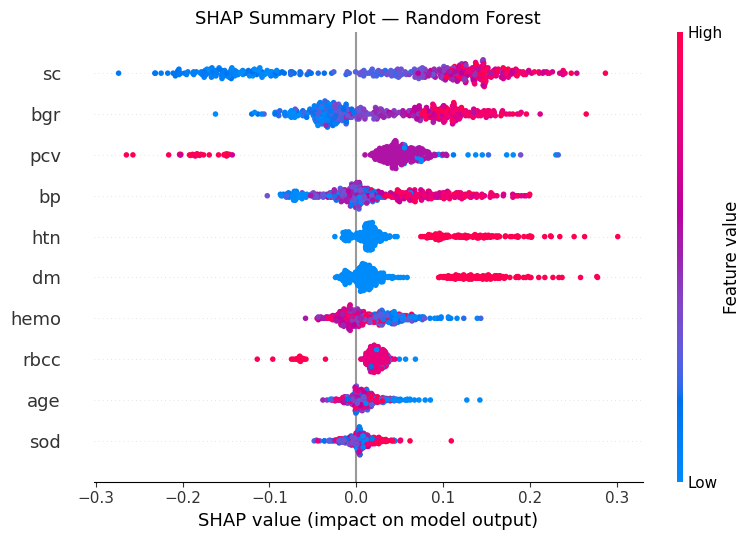

📊 Saved: shap_summary.png


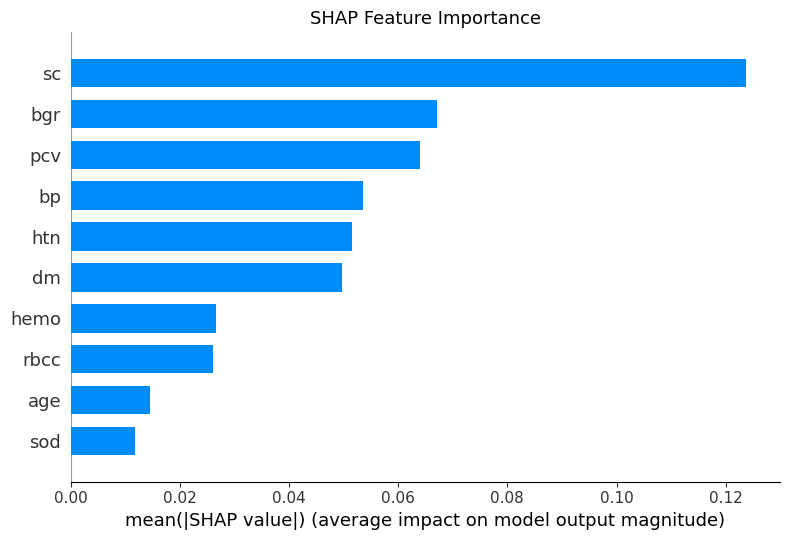

📊 Saved: shap_bar.png

Top Features by SHAP:
Feature  Mean |SHAP|
     sc     0.123761
    bgr     0.067105
    pcv     0.064004
     bp     0.053472
    htn     0.051562
     dm     0.049740
   hemo     0.026626
   rbcc     0.026151
    age     0.014499
    sod     0.011797


In [22]:
# ─────────────────────────────────────────────
# 19. SHAP EXPLAINABILITY (Best Model)
# ─────────────────────────────────────────────
print('STEP 17: SHAP EXPLAINABILITY')
print('-' * 45)

# Best tree-based model খুঁজে বের করা SHAP এর জন্য
tree_models = ['Hist Gradient Boosting', 'Gradient Boosting',
               'Random Forest', 'XGBoost', 'Decision Tree']
shap_model_nm = next(
    (nm for nm in te_df['Test AUC-ROC'].sort_values(ascending=False).index
     if nm in tree_models and nm in trained),
    None
)

if shap_model_nm is None:
    shap_model_nm = list(trained.keys())[0]

print(f'SHAP analysis model: {shap_model_nm}')
shap_clf = trained[shap_model_nm]

explainer = shap.TreeExplainer(shap_clf)
sv = explainer.shap_values(X_te_sel)

if isinstance(sv, list):
    sv = sv[1]
elif hasattr(sv, 'ndim') and sv.ndim == 3:
    sv = sv[:, :, 1]

fl = list(feat_names)

# Beeswarm plot
plt.figure(figsize=(10, 6))
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='dot')
plt.title(f'SHAP Summary Plot — {shap_model_nm}', fontsize=13)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: shap_summary.png')

# Bar plot
plt.figure(figsize=(9, 5))
shap.summary_plot(sv, X_te_sel, feature_names=fl, show=False, plot_type='bar')
plt.title('SHAP Feature Importance', fontsize=13)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()
print('📊 Saved: shap_bar.png')

shap_imp = pd.DataFrame({
    'Feature':     fl,
    'Mean |SHAP|': np.abs(sv).mean(axis=0)
}).sort_values('Mean |SHAP|', ascending=False)

print('\nTop Features by SHAP:')
print(shap_imp.to_string(index=False))

In [23]:
# ─────────────────────────────────────────────
# 20. SAVE ALL RESULTS
# ─────────────────────────────────────────────
print('STEP 18: SAVING ALL RESULTS')
print('-' * 45)

cv_df.to_csv('cv_results.csv')
print('💾 Saved: cv_results.csv')

all_r.round(4).to_csv('test_results.csv')
print('💾 Saved: test_results.csv')

shap_imp.to_csv('shap_importance.csv', index=False)
print('💾 Saved: shap_importance.csv')

# Tuning results save
tuning_df = pd.DataFrame({
    nm: {'Best CV AUC': r['Best CV AUC'],
         'Best Params': str(r['Best Params'])}
    for nm, r in tuning_results.items()
}).T
tuning_df.to_csv('tuning_results.csv')
print('💾 Saved: tuning_results.csv')

STEP 18: SAVING ALL RESULTS
---------------------------------------------
💾 Saved: cv_results.csv
💾 Saved: test_results.csv
💾 Saved: shap_importance.csv
💾 Saved: tuning_results.csv


In [24]:
# ─────────────────────────────────────────────
# FINAL SUMMARY
# ─────────────────────────────────────────────
print('\n' + '=' * 65)
print('  FINAL SUMMARY — IMPROVED PIPELINE')
print('=' * 65)

print('\n📋 Cross-Validation Results (Tuned Models):')
print(cv_df.drop(columns=['CV Acc Std']).to_string())

print('\n📋 Test Set Results:')
print(all_r.round(4).to_string())

print(f'\n🏆 Best Individual Model : {best_nm}')
print(f'   Accuracy             : {best_ac:.4f} | 95% CI:[{ci_l:.3f},{ci_h:.3f}]')

print(f'\n🏆 Soft Voting Ensemble (Top-3: {top3_names})')
print(f'   Acc:{ea:.4f} | F1:{ef:.4f} | AUC:{eu:.4f}')

print(f'\n🔑 Top-5 SHAP Features:')
for _, r in shap_imp.head(5).iterrows():
    print(f'   {r["Feature"]:15s} → {r["Mean |SHAP|"]:4f}')

print("""
✅ Pipeline সম্পন্ন! Output files:
   📄 merged_ckd_dataset.csv
   📊 feature_selection_votes.png
   📊 confusion_matrices.png
   📊 roc_curves.png          ← NEW
   📊 pr_curves.png           ← NEW
   📊 learning_curves.png     ← NEW
   📊 model_comparison.png
   📊 shap_summary.png
   📊 shap_bar.png
   📄 cv_results.csv
   📄 test_results.csv
   📄 shap_importance.csv
   📄 tuning_results.csv      ← NEW
""")


  FINAL SUMMARY — IMPROVED PIPELINE

📋 Cross-Validation Results (Tuned Models):
                        CV Accuracy   CV F1  CV AUC-ROC
Random Forest                0.9412  0.9421      0.9843
Gradient Boosting            0.9475  0.9478      0.9865
Hist Gradient Boosting       0.9493  0.9496      0.9853
SVM                          0.9369  0.9362      0.9807
KNN                          0.9253  0.9213      0.9821
Logistic Regression          0.7960  0.8051      0.8855
Decision Tree                0.8679  0.8643      0.9428
XGBoost                      0.9387  0.9392      0.9846

📋 Test Set Results:
                        Test Accuracy  Test F1  Test AUC-ROC
Random Forest                  0.9053   0.9459        0.8692
Gradient Boosting              0.9078   0.9474        0.8489
Hist Gradient Boosting         0.9029   0.9444        0.8527
SVM                            0.8689   0.9235        0.7811
KNN                            0.8350   0.9006        0.8277
Logistic Regression         